In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import os

import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

In [2]:
### READ DATA ###

df = pd.read_csv('HRSS_anomalous_optimized.csv.zip')

print(df.shape)
df.head()

(19634, 20)


Timestamp  Labels  I_w_BLO_Weg  O_w_BLO_power  O_w_BLO_voltage  \
0   0.000000       0          7.0            0.0              0.0   
1   0.043999       0          7.0            0.0              0.0   
2   0.099998       0          7.0            0.0              0.0   
3   0.143997       0          7.0            0.0              0.0   
4   0.249001       0          7.0            0.0              0.0   

   I_w_BHL_Weg  O_w_BHL_power  O_w_BHL_voltage  I_w_BHR_Weg  O_w_BHR_power  \
0       -547.0            0.0              0.0       -874.0           12.0   
1       -547.0            0.0              0.0       -874.0           12.0   
2       -547.0            0.0              0.0       -874.0           12.0   
3       -547.0            0.0              0.0       -874.0           12.0   
4       -547.0            0.0              0.0       -874.0            7.0   

   O_w_BHR_voltage  I_w_BRU_Weg  O_w_BRU_power  O_w_BRU_voltage  I_w_HR_Weg  \
0              1.0        -32.0            0.0              0.0         0.0   
1              1.0        -32.0            0.0              0.0         0.0   
2              1.0        -32.0            0.0              0.0         0.0   
3              1.0        -32.0            0.0              0.0         0.0   
4              1.0         22.0        18471.0             47.0         0.0   

   O_w_HR_power  O_w_HR_voltage  I_w_HL_Weg  O_w_HL_power  O_w_HL_voltage  
0        2560.0            24.0         0.0        3434.0            24.0  
1        2560.0            24.0         0.0        3434.0            24.0  
2        2560.0            24.0         0.0        3434.0            24.0  
3        2560.0            24.0         0.0        3434.0            24.0  
4        5764.0            26.0         0.0        5008.0            24.0

In [3]:
features = ['I_w_BLO_Weg', 'O_w_BLO_power', 'O_w_BLO_voltage', 'I_w_BHL_Weg', 
            'O_w_BHL_power', 'O_w_BHL_voltage', 'I_w_BHR_Weg', 'O_w_BHR_power', 
            'O_w_BHR_voltage', 'I_w_BRU_Weg', 'O_w_BRU_power', 'O_w_BRU_voltage', 
            'I_w_HR_Weg', 'O_w_HR_power', 'O_w_HR_voltage', 'I_w_HL_Weg', 
            'O_w_HL_power', 'O_w_HL_voltage']

In [4]:
### LABEL DISTRIBUTION ###

df.Labels.value_counts()

0    15117
1     4517
Name: Labels, dtype: int64

Text(0, 0.5, 'Failure')

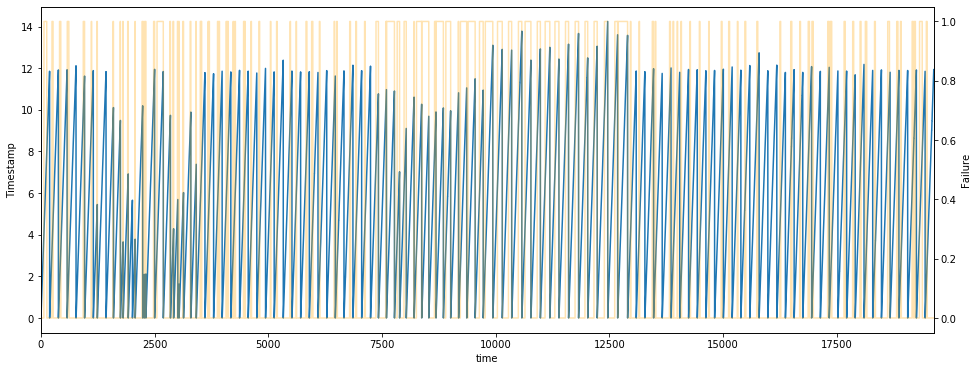

In [5]:
### CYCLE vs LABEL DISTRIBUTION ###

df.Timestamp.plot(figsize=(16,6))
plt.xlabel('time')
plt.ylabel('Timestamp')
plt.twinx()
plt.plot(df.Labels, alpha=0.3, c='orange')
plt.ylabel('Failure')

Text(0, 0.5, 'standard deviation')

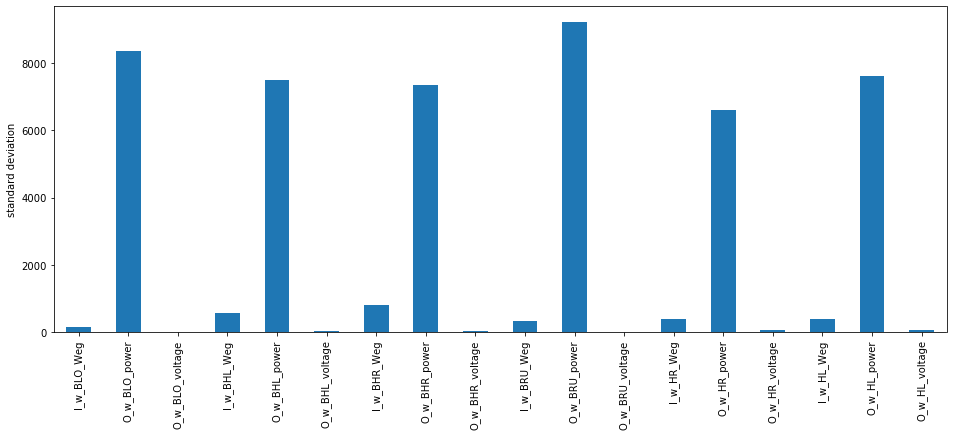

In [6]:
### SENSOR FEATURES VARIANCE ###

df.loc[:,features].std().plot.bar(figsize=(16,6))
plt.ylabel('standard deviation')

In [7]:
### UTILITY FUNCTION TO GENERATE SEQUENCE FOR LSTM ###

def gen_sequence(df, seq_length):
    
    seq_df = []
    
    for start, stop in zip(range(0, len(df)-seq_length), range(seq_length, len(df))):
        seq_df.append(df[start:stop, :])
        
    return np.asarray(seq_df)

In [8]:
### RETRIVE CYCLE NUMBER ###

k = -1
cycle = []
for i,time in df.Timestamp.iteritems(): 
    if time==0.:
        k += 1
        cycle.append(k)
    else:
        cycle.append(k)
        
df['Timestamp'] = cycle

In [9]:
### CREATE AND STANDARDIZE WINDOW SEQUENCES FOR EVERY CYCLE ###

sequence_length = 8
test_size = 0.1

X_train, X_test = [], []
Y_train, Y_test = [], []

for k,group_df in df.groupby('Timestamp'):
    
    if int(len(group_df)*test_size) > sequence_length: # at least the dimension of the test
    
        init = group_df[features].values[0] + 1e-3
        y = group_df.Labels.values
        x_train = group_df[features].values[:int(len(group_df)*(1-test_size))] / init
        x_test = group_df[features].values[int(len(group_df)*(1-test_size)):] / init

        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        x_train = gen_sequence(x_train, sequence_length)
        x_test = gen_sequence(x_test, sequence_length)
        y_train = y[sequence_length:int(len(group_df)*(1-test_size))]
        y_test = y[int(len(group_df)*(1-test_size))+sequence_length:]

        Y_train.append(y_train); Y_test.append(y_test)
        X_train.append(x_train); X_test.append(x_test)
    
    else:
        continue
    
X_train, X_test = np.vstack(X_train), np.vstack(X_test)
print(X_train.shape, X_test.shape)
Y_train, Y_test = np.concatenate(Y_train), np.concatenate(Y_test)
print(Y_train.shape, Y_test.shape)

(16445, 8, 18) (1148, 8, 18)
(16445,) (1148,)


In [10]:
### LABEL DISTRIBUTION OF TEST SET ###

pd.value_counts(Y_test)

0    710
1    438
dtype: int64

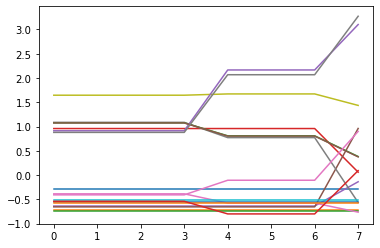

In [11]:
### PLOT EXEMPLE OF SAMPLE ###

_id_ = 39

plt.plot(X_train[_id_])
np.set_printoptions(False)

In [12]:
### GENERATE PAIR SAMPLES FOR SIAMESE NETWORK ###

os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

left_input = []
right_input = []
targets = []
pairs = 3

for i in range(len(Y_train)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i:
            compare_to = random.randint(0,len(Y_train)-1)
        left_input.append(X_train[i])
        right_input.append(X_train[compare_to])
        if Y_train[i] == Y_train[compare_to]: # They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.asarray(left_input).reshape(-1, sequence_length, len(features))
right_input = np.asarray(right_input).reshape(-1, sequence_length, len(features))
targets = np.asarray(targets)
print(left_input.shape, right_input.shape, targets.shape)

(49335, 8, 18) (49335, 8, 18) (49335,)


In [13]:
### LABEL DISTRIBUTION OF AUGMENTED DATASET ###

pd.value_counts(targets)

1.0    32570
0.0    16765
dtype: int64

In [14]:
### DEFINE SIAMESE NETWORK ARCHITECTURE ###

def SiamesNet():
    
    left_input = Input((sequence_length, len(features)))
    right_input = Input((sequence_length, len(features)))

    lstmnet = Sequential([
        BatchNormalization(),
        LSTM(128, activation='relu', return_sequences=True, input_shape=(sequence_length, len(features))),
        LSTM(32, activation='relu')
    ])

    encoded_l = lstmnet(left_input)
    encoded_r = lstmnet(right_input)

    L1_layer = Lambda(lambda tensor: K.abs(tensor[0] - tensor[1]))

    L1_distance = L1_layer([encoded_l, encoded_r])
    drop = Dropout(0.2)(L1_distance)
    prediction = Dense(1,activation='sigmoid')(drop)
    model = Model(inputs=[left_input,right_input],outputs=prediction)
    
    return model

In [15]:
### SET SEED ###
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


### FIT SIAMESE NETWORK ###

siamese_net = SiamesNet()
siamese_net.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-3), metrics=['accuracy'])

siamese_net.fit([left_input, right_input], targets, batch_size=512, epochs=50, 
                validation_split=0.15, verbose=2)

Train on 41934 samples, validate on 7401 samples
Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
41934/41934 - 21s - loss: 0.6449 - accuracy: 0.6539 - val_loss: 0.6312 - val_accuracy: 0.6749
Epoch 2/50
41934/41934 - 11s - loss: 0.6285 - accuracy: 0.6659 - val_loss: 0.6134 - val_accuracy: 0.6872
Epoch 3/50
41934/41934 - 11s - loss: 0.6124 - accuracy: 0.6827 - val_loss: 0.6052 - val_accuracy: 0.7006
Epoch 4/50
41934/41934 - 14s - loss: 0.5998 - accuracy: 0.6970 - val_loss: 0.6014 - val_accuracy: 0.7031
Epoch 5/50
41934/41934 - 12s - loss: 0.5899 - accuracy: 0.7076 - val_loss: 0.5993 - val_accuracy: 0.7018
Epoch 6/50
41934/41934 - 14s - loss: 0.5819 - accuracy: 0.7165 - val_loss: 0.5869 - val_accuracy: 0.7104
Epoch 7/50
41934/41934 - 10s - loss: 0.5707 - accuracy: 0.7269 - val_loss: 0.5856 - val_accuracy: 0.7165
Epoch 8/50
41934/41934 - 10s - loss: 0.5605 - accuracy: 0.7335 - val_loss: 0.5843 - val_accuracy: 0.7095
Epoch 9/50
41934/

In [16]:
### COMPUTE PREDICTION ###

os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

real = []
pred = []
rep = 4

for j,i in enumerate(tqdm.tqdm(Y_test)):
    
    test = X_test[j]

    nofault = np.random.choice(np.where(Y_train == 0)[0], rep)
    nofault = X_train[nofault]
    nofault_sim = np.max([float(siamese_net.predict([test[np.newaxis,:,:],s[np.newaxis,:,:]])) for s in nofault])

    fault = np.random.choice(np.where(Y_train == 1)[0], rep)
    fault = X_train[fault]
    fault_sim = np.max([float(siamese_net.predict([test[np.newaxis,:,:],s[np.newaxis,:,:]])) for s in fault])
    
    pred.append('nofault' if nofault_sim > fault_sim else 'fault')
    real.append('nofault' if i == 0 else 'fault')

100%|██████████████████████████████████████████████████████████████████████████████| 1148/1148 [07:16<00:00,  2.63it/s]


In [17]:
print(classification_report(real, pred))

              precision    recall  f1-score   support

       fault       0.82      0.15      0.26       438
     nofault       0.65      0.98      0.78       710

    accuracy                           0.66      1148
   macro avg       0.73      0.57      0.52      1148
weighted avg       0.71      0.66      0.58      1148



In [18]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

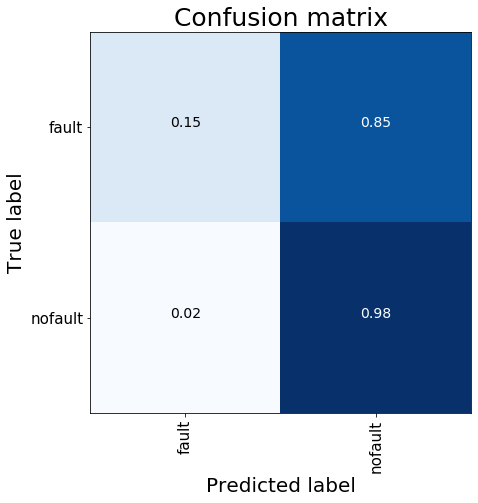

In [19]:
cnf_matrix = confusion_matrix(real, pred)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(real), title="Confusion matrix")
plt.show()

In [20]:
### DUMMY CLASSIFIER ACCURACY (always nofault) ###

sum(np.asarray(real) == 'nofault') / (sum(np.asarray(real) == 'fault') + sum(np.asarray(real) == 'nofault'))

0.6184668989547039